In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import geopandas as gpd
%matplotlib inline

In [2]:
from urbansim_templates import modelmanager as mm
from urbansim_templates.models import LargeMultinomialLogitStep
import orca
import os; os.chdir('../')
import warnings;warnings.simplefilter('ignore')
from scripts import datasources, models, variables

In [3]:
orca.run(['initialize_network_small', 'initialize_network_walk'])

Running step 'initialize_network_small'
Time to execute step 'initialize_network_small': 0.00 s
Running step 'initialize_network_walk'
Time to execute step 'initialize_network_walk': 0.00 s
Total time to execute iteration 1 with iteration value None: 0.00 s


# Compare Distribution of Jobs in UrbanSim and LODES _before_ WLCM

#### Load UrbanSim job counts

In [4]:
synth_jobs_geog = orca.merge_tables('jobs',['jobs', 'buildings', 'parcels'])[['block_id']]
synth_job_block_counts = synth_jobs_geog.reset_index().groupby('block_id').count().rename(columns={'job_id': 'jobs'})
synth_job_block_counts['pct_jobs'] = synth_job_block_counts['jobs'] / synth_job_block_counts['jobs'].sum()

#### Load LODES job counts

In [5]:
lodes_job_block_counts = pd.read_csv(
    './data/ca_wac_S000_JT01_2011.csv.gz',
    dtype={'w_geocode': str}, usecols=['w_geocode', 'C000'],
    compression='gzip'
).rename(columns={'C000': 'jobs'})
lodes_job_block_counts['pct_jobs'] = lodes_job_block_counts['jobs'] / lodes_job_block_counts['jobs'].sum()

#### Merge UrbanSim Jobs with LODES

In [6]:
merged_job_block_counts = pd.merge(
    synth_job_block_counts, lodes_job_block_counts, left_index=True, right_on='w_geocode', suffixes=('_synth', '_lodes'))

merged_job_block_counts['pct_diff'] = (merged_job_block_counts['jobs_lodes'] - merged_job_block_counts['jobs_synth']) / merged_job_block_counts['jobs_lodes'] * 100
merged_job_block_counts['normed_pct_diff'] = (merged_job_block_counts['pct_jobs_lodes'] - merged_job_block_counts['pct_jobs_synth'])

#### Merge UrbanSim and LODES Jobs with Blocks Shapefile

In [9]:
blocks_geog = gpd.read_file('./data/Blocks/bayarea_blocks.shp')

blocks_geog_lodes_jobs = blocks_geog.merge(lodes_job_block_counts, left_on='blockid10', right_on='w_geocode')
blocks_geog_lodes_jobs['job_density'] = np.log(blocks_geog_lodes_jobs['jobs'] / blocks_geog_lodes_jobs['area'])

blocks_geog_synth_jobs = blocks_geog.merge(synth_job_block_counts, left_on='blockid10', right_on='block_id')
blocks_geog_synth_jobs['job_density'] = np.log(blocks_geog_synth_jobs['jobs'] / blocks_geog_synth_jobs['area'])

blocks_geog_merged_jobs = blocks_geog.merge(merged_job_block_counts, left_on='blockid10', right_on='w_geocode')
blocks_geog_merged_jobs['job_density_synth'] = blocks_geog_merged_jobs['jobs_synth'] / blocks_geog_merged_jobs['area']
blocks_geog_merged_jobs['job_density_lodes'] = blocks_geog_merged_jobs['jobs_lodes'] / blocks_geog_merged_jobs['area']
blocks_geog_merged_jobs['pct_diff_job_density'] = (blocks_geog_merged_jobs['job_density_lodes'] - blocks_geog_merged_jobs['job_density_synth']) / blocks_geog_merged_jobs['job_density_lodes'] * 100

#### Plots

Text(0.5,0,'LEHD Jobs')

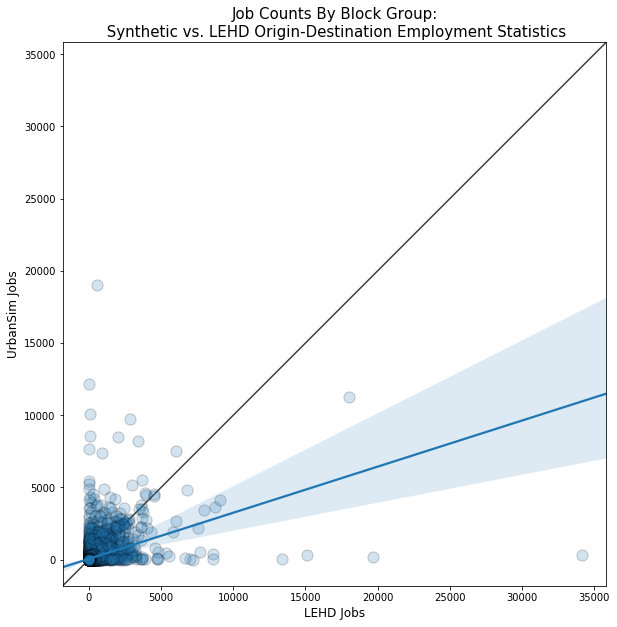

In [10]:
fig, ax = plt.subplots(figsize=(10,10))
sns.regplot(
    'jobs_lodes', 'jobs_synth', merged_job_block_counts,
    ax=ax, marker='.', fit_reg=True,
    scatter_kws={"s": 500, "edgecolor": 'k', "alpha": 0.2})

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_title('Job Counts By Block Group:\n Synthetic vs. LEHD Origin-Destination Employment Statistics', fontsize=15)
ax.set_ylabel('UrbanSim Jobs', fontsize=12)
ax.set_xlabel('LEHD Jobs', fontsize=12)

Text(0.5,0.98,'Job Density by Census Block')

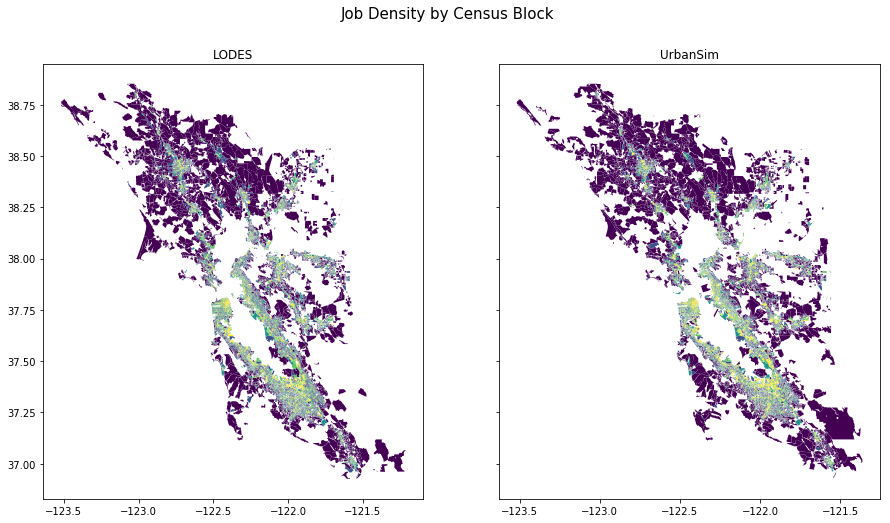

In [11]:
fig, axarr = plt.subplots(1, 2, figsize=(15,8), sharey=True)

blocks_geog_lodes_jobs.plot(column='job_density', scheme='quantiles', ax=axarr[0])
blocks_geog_synth_jobs.plot(column='job_density', scheme='quantiles', ax=axarr[1])

axarr[0].set_title('LODES')
axarr[1].set_title('UrbanSim')
fig.suptitle('Job Density by Census Block', fontsize=15)

(-4000, 300)

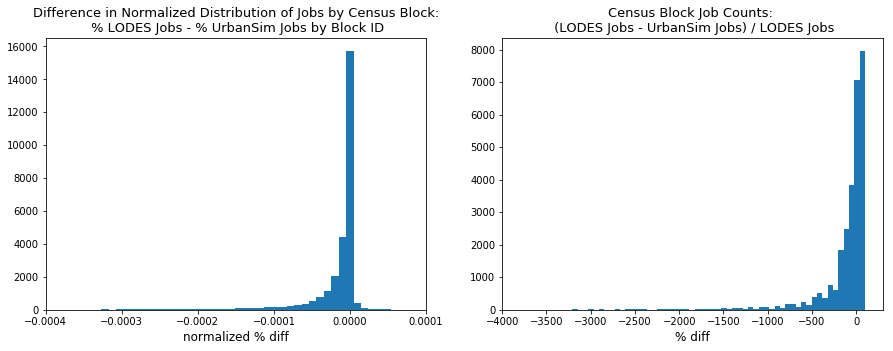

In [12]:
fig, axarr = plt.subplots(1,2, figsize=(15,5))

_ = axarr[0].hist(merged_job_block_counts['normed_pct_diff'][merged_job_block_counts['jobs_lodes'] > 0], bins=1000)
axarr[0].set_xlabel('normalized % diff', fontsize=12)
axarr[0].set_title('Difference in Normalized Distribution of Jobs by Census Block:\n '
            '% LODES Jobs - % UrbanSim Jobs by Block ID', fontsize=13)
axarr[0].set_xlim(-0.0004, 0.0001)

_ = axarr[1].hist(merged_job_block_counts['pct_diff'][merged_job_block_counts['jobs_lodes'] > 0], bins=2500)
axarr[1].set_xlabel('% diff', fontsize=12)
axarr[1].set_title('Census Block Job Counts: \n (LODES Jobs - UrbanSim Jobs) / LODES Jobs', fontsize=13)
axarr[1].set_xlim(-4000,300)

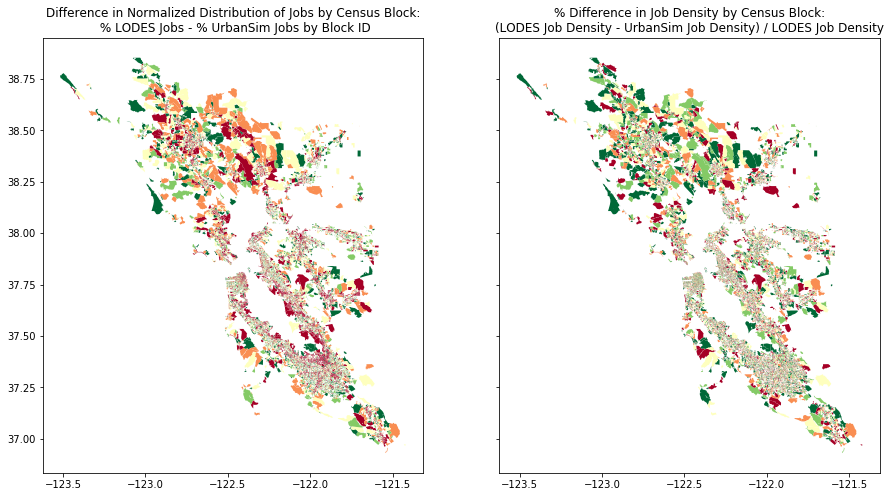

In [15]:
fig, axarr = plt.subplots(1, 2, figsize=(15,8), sharey=True)

blocks_geog_merged_jobs.plot(column='normed_pct_diff', scheme='quantiles', cmap='RdYlGn', ax=axarr[0])
blocks_geog_merged_jobs.plot(column='pct_diff_job_density', scheme='quantiles', cmap='RdYlGn', ax=axarr[1])

_ = axarr[0].set_title('Difference in Normalized Distribution of Jobs by Census Block:\n '
            '% LODES Jobs - % UrbanSim Jobs by Block ID')
_ = axarr[1].set_title('% Difference in Job Density by Census Block:\n'
                  '(LODES Job Density - UrbanSim Job Density) / LODES Job Density')

In [14]:
total_lodes_jobs = merged_job_block_counts['jobs_lodes'].sum()
total_synth_jobs = merged_job_block_counts['jobs_synth'].sum()
pct_diff = (total_lodes_jobs - total_synth_jobs) / total_lodes_jobs * 100
print('{0}% difference in total jobs count between LODES and UrbanSim'.format(np.round(pct_diff, 1)))

4.4% difference in total jobs count between LODES and UrbanSim


# Compare Distribution of "Commute" Flows _after_ WLCM

#### Load WLCM Output

In [4]:
persons_w_jobs = pd.read_csv('./data/persons_w_jobs_2018_10_26.csv', index_col='person_id')
orca.add_table('persons', persons_w_jobs)
orca.broadcast('jobs', 'persons', cast_index=True, onto_on='job_id')

#### Aggregate WLCM-assigned commute flows

In [5]:
df_hh_geog = orca.merge_tables('persons', ['persons', 'households', 'units', 'buildings', 'parcels'])[['block_id']]

In [6]:
df_w_geog = orca.merge_tables('persons', ['persons', 'jobs', 'buildings', 'parcels'])[['block_id']]

In [7]:
wlcm_ods = pd.merge(df_hh_geog, df_w_geog, left_index=True, right_index=True, suffixes=('_h', '_w'))
wlcm_ods['tract_id_h'] = wlcm_ods['block_id_h'].str[0:11]
wlcm_ods['county_id_h'] = wlcm_ods['block_id_h'].str[0:5]
wlcm_ods['tract_id_w'] = wlcm_ods['block_id_w'].str[0:11]
wlcm_ods['county_id_w'] = wlcm_ods['block_id_w'].str[0:5]
wlcm_ods = wlcm_ods[['county_id_h', 'county_id_w', 'tract_id_h', 'tract_id_w', 'block_id_h', 'block_id_w']]

In [8]:
wlcm_od_county_counts = wlcm_ods[['county_id_h', 'county_id_w']].reset_index().groupby(['county_id_h', 'county_id_w']).count().reset_index().rename(columns={'person_id': 'count'})
wlcm_od_tract_counts = wlcm_ods[['tract_id_h', 'tract_id_w']].reset_index().groupby(['tract_id_h', 'tract_id_w']).count().reset_index().rename(columns={'person_id': 'count'})

#### Aggregate LODES commute flows

In [9]:
lodes_ods = pd.read_csv(
    './data/ca_od_main_JT01_2011.csv.gz',
    dtype={'w_geocode': str, 'h_geocode': str}, usecols=['w_geocode', 'h_geocode', 'S000'],
    compression='gzip')

lodes_ods['tract_id_h'] = lodes_ods['h_geocode'].str[0:11]
lodes_ods['county_id_h'] = lodes_ods['h_geocode'].str[0:5]
lodes_ods['tract_id_w'] = lodes_ods['w_geocode'].str[0:11]
lodes_ods['county_id_w'] = lodes_ods['w_geocode'].str[0:5]

lodes_od_county_counts = lodes_ods[['county_id_h', 'county_id_w', 'S000']].groupby(['county_id_h', 'county_id_w']).sum().reset_index().rename(columns={'S000': 'count'})
lodes_od_tract_counts = lodes_ods[['tract_id_h', 'tract_id_w', 'S000']].groupby(['tract_id_h', 'tract_id_w']).sum().reset_index().rename(columns={'S000': 'count'})

#### Merge WLCM results with LODES

In [11]:
merged_od_county_counts = pd.merge(wlcm_od_county_counts, lodes_od_county_counts, on=['county_id_h', 'county_id_w'], suffixes=('_synth', '_lodes'))
merged_od_tract_counts = pd.merge(wlcm_od_tract_counts, lodes_od_tract_counts, on=['tract_id_h', 'tract_id_w'], suffixes=('_synth', '_lodes'))

In [12]:
merged_od_county_counts['pct_synth'] = merged_od_county_counts['count_synth'] / merged_od_county_counts['count_synth'].sum()
merged_od_county_counts['pct_lodes'] = merged_od_county_counts['count_lodes'] / merged_od_county_counts['count_lodes'].sum()
merged_od_county_counts['normed_pct_diff'] = merged_od_county_counts['pct_lodes'] - merged_od_county_counts['pct_synth']
merged_od_county_counts['pct_diff'] = (merged_od_county_counts['count_lodes'] - merged_od_county_counts['count_synth']) / merged_od_county_counts['count_lodes'] * 100

merged_od_tract_counts['pct_synth'] = merged_od_tract_counts['count_synth'] / merged_od_tract_counts['count_synth'].sum()
merged_od_tract_counts['pct_lodes'] = merged_od_tract_counts['count_lodes'] / merged_od_tract_counts['count_lodes'].sum()
merged_od_tract_counts['normed_pct_diff'] = merged_od_tract_counts['pct_lodes'] - merged_od_tract_counts['pct_synth']

#### Plots

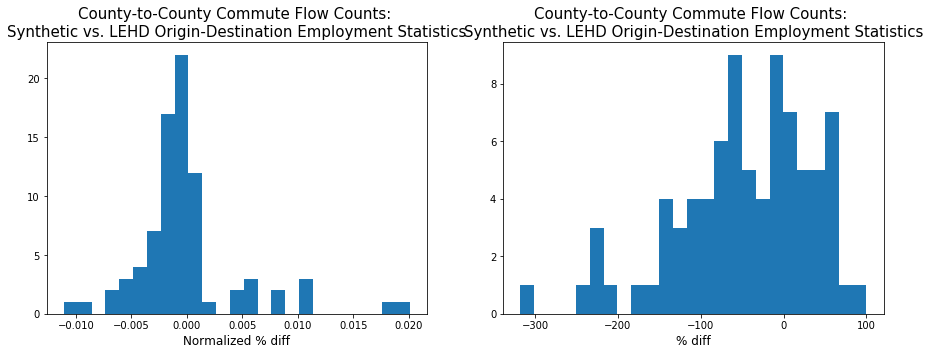

In [13]:
fig, axarr = plt.subplots(1,2, figsize=(15,5))

_ = axarr[0].hist(merged_od_county_counts['normed_pct_diff'], bins=25)
axarr[0].set_xlabel('Normalized % diff', fontsize=12)
_ = axarr[0].set_title('County-to-County Commute Flow Counts: \nSynthetic vs. LEHD Origin-Destination Employment Statistics', fontsize=15)

_ = axarr[1].hist(merged_od_county_counts['pct_diff'], bins=25)
axarr[1].set_xlabel('% diff', fontsize=12)
_ = axarr[1].set_title('County-to-County Commute Flow Counts: \nSynthetic vs. LEHD Origin-Destination Employment Statistics', fontsize=15)

Text(6706,133539,'Contra Costa')

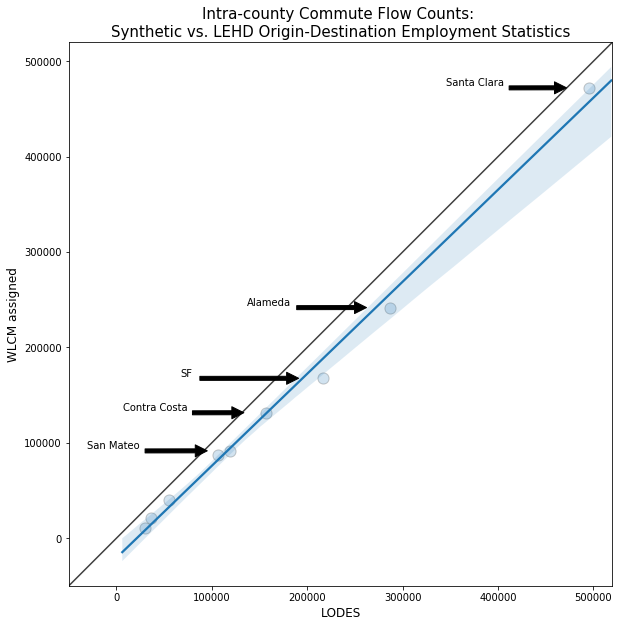

In [14]:
fig, ax = plt.subplots(figsize=(10,10))
plot_df = merged_od_county_counts[merged_od_county_counts['county_id_h'] == merged_od_county_counts['county_id_w']]
sns.regplot(
    'count_lodes', 'count_synth', plot_df,
    ax=ax, marker='.', fit_reg=True,
    scatter_kws={"s": 500, "edgecolor": 'k', "alpha": 0.2})

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_title('Intra-county Commute Flow Counts: \nSynthetic vs. LEHD Origin-Destination Employment Statistics', fontsize=15)
ax.set_ylabel('WLCM assigned', fontsize=12)
ax.set_xlabel('LODES', fontsize=12)

## label specific points
# Alameda to SF commute
row = plot_df[(plot_df['county_id_h'] == '06001') & (plot_df['county_id_w'] == '06001')]
ax.annotate(
    'Alameda',
    xy=(row['count_lodes'] - 20000,row['count_synth']),
    xytext=(row['count_lodes'] - 150000, row['count_synth'] + 2000),
    arrowprops=dict(facecolor='black', shrink=0.05)
)

row = plot_df[(plot_df['county_id_h'] == '06075') & (plot_df['county_id_w'] == '06075')]
ax.annotate(
    'SF',
    xy=(row['count_lodes'] - 20000,row['count_synth']),
    xytext=(row['count_lodes'] - 150000, row['count_synth'] + 2000),
    arrowprops=dict(facecolor='black', shrink=0.05)
)

row = plot_df[(plot_df['county_id_h'] == '06081') & (plot_df['county_id_w'] == '06081')]
ax.annotate(
    'San Mateo',
    xy=(row['count_lodes'] - 20000,row['count_synth']),
    xytext=(row['count_lodes'] - 150000, row['count_synth'] + 2000),
    arrowprops=dict(facecolor='black', shrink=0.05)
)

row = plot_df[(plot_df['county_id_h'] == '06085') & (plot_df['county_id_w'] == '06085')]
ax.annotate(
    'Santa Clara',
    xy=(row['count_lodes'] - 20000,row['count_synth']),
    xytext=(row['count_lodes'] - 150000, row['count_synth'] + 2000),
    arrowprops=dict(facecolor='black', shrink=0.05)
)


row = plot_df[(plot_df['county_id_h'] == '06013') & (plot_df['county_id_w'] == '06013')]
ax.annotate(
    'Contra Costa',
    xy=(row['count_lodes'] - 20000,row['count_synth']),
    xytext=(row['count_lodes'] - 150000, row['count_synth'] + 2000),
    arrowprops=dict(facecolor='black', shrink=0.05)
)


Text(3620,72780,'Santa Clara --> Alameda')

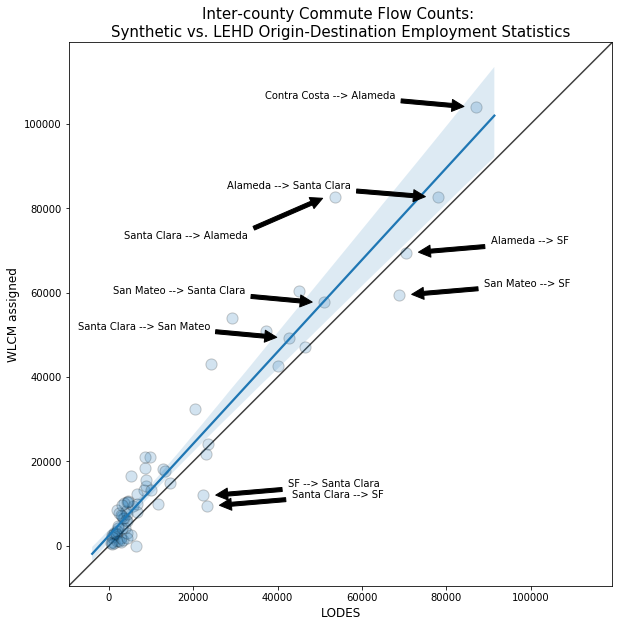

In [15]:
fig, ax = plt.subplots(figsize=(10,10))
plot_df = merged_od_county_counts[merged_od_county_counts['county_id_h'] != merged_od_county_counts['county_id_w']]
sns.regplot(
    'count_lodes', 'count_synth', plot_df,
    ax=ax, marker='.', fit_reg=True,
    scatter_kws={"s": 500, "edgecolor": 'k', "alpha": 0.2})

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_title('Inter-county Commute Flow Counts: \nSynthetic vs. LEHD Origin-Destination Employment Statistics', fontsize=15)
ax.set_ylabel('WLCM assigned', fontsize=12)
ax.set_xlabel('LODES', fontsize=12)

## label specific points
# Alameda to SF commute
row = plot_df[(plot_df['county_id_h'] == '06001') & (plot_df['county_id_w'] == '06075')]
ax.annotate(
    'Alameda --> SF',
    xy=(row['count_lodes']+2000,row['count_synth']),
    xytext=(row['count_lodes'] + 20000, row['count_synth'] + 2000),
    arrowprops=dict(facecolor='black', shrink=0.05)
)

row = plot_df[(plot_df['county_id_h'] == '06075') & (plot_df['county_id_w'] == '06085')]
ax.annotate(
    'SF --> Santa Clara',
    xy=(row['count_lodes']+2000,row['count_synth']),
    xytext=(row['count_lodes'] + 20000, row['count_synth'] + 2000),
    arrowprops=dict(facecolor='black', shrink=0.05)
)

row = plot_df[(plot_df['county_id_h'] == '06081') & (plot_df['county_id_w'] == '06075')]
ax.annotate(
    'San Mateo --> SF',
    xy=(row['count_lodes']+2000,row['count_synth']),
    xytext=(row['count_lodes'] + 20000, row['count_synth'] + 2000),
    arrowprops=dict(facecolor='black', shrink=0.05)
)

row = plot_df[(plot_df['county_id_h'] == '06085') & (plot_df['county_id_w'] == '06075')]
ax.annotate(
    'Santa Clara --> SF',
    xy=(row['count_lodes']+2000,row['count_synth']),
    xytext=(row['count_lodes'] + 20000, row['count_synth'] + 2000),
    arrowprops=dict(facecolor='black', shrink=0.05)
)

row = plot_df[(plot_df['county_id_h'] == '06081') & (plot_df['county_id_w'] == '06085')]
ax.annotate(
    'San Mateo --> Santa Clara',
    xy=(row['count_lodes']-2000,row['count_synth']),
    xytext=(row['count_lodes'] - 50000, row['count_synth'] + 2000),
    arrowprops=dict(facecolor='black', shrink=0.05)
)

row = plot_df[(plot_df['county_id_h'] == '06085') & (plot_df['county_id_w'] == '06081')]
ax.annotate(
    'Santa Clara --> San Mateo',
    xy=(row['count_lodes']-2000,row['count_synth']),
    xytext=(row['count_lodes'] - 50000, row['count_synth'] + 2000),
    arrowprops=dict(facecolor='black', shrink=0.05)
)

row = plot_df[(plot_df['county_id_h'] == '06013') & (plot_df['county_id_w'] == '06001')]
ax.annotate(
    'Contra Costa --> Alameda',
    xy=(row['count_lodes']-2000,row['count_synth']),
    xytext=(row['count_lodes'] - 50000, row['count_synth'] + 2000),
    arrowprops=dict(facecolor='black', shrink=0.05)
)

row = plot_df[(plot_df['county_id_h'] == '06001') & (plot_df['county_id_w'] == '06085')]
ax.annotate(
    'Alameda --> Santa Clara',
    xy=(row['count_lodes']-2000,row['count_synth']),
    xytext=(row['count_lodes'] - 50000, row['count_synth'] + 2000),
    arrowprops=dict(facecolor='black', shrink=0.05)
)


row = plot_df[(plot_df['county_id_h'] == '06085') & (plot_df['county_id_w'] == '06001')]
ax.annotate(
    'Santa Clara --> Alameda',
    xy=(row['count_lodes']-2000,row['count_synth']),
    xytext=(row['count_lodes'] - 50000, row['count_synth'] - 10000),
    arrowprops=dict(facecolor='black', shrink=0.05)
)

Text(0.5,0,'LODES')

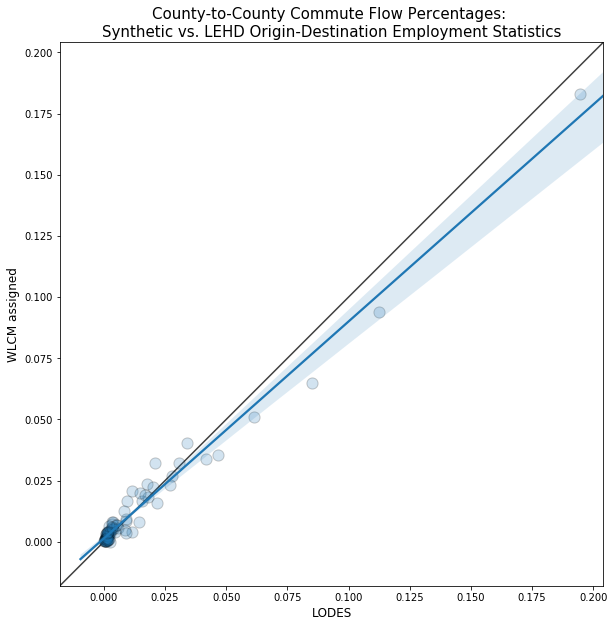

In [16]:
fig, ax = plt.subplots(figsize=(10,10))
sns.regplot(
    'pct_lodes', 'pct_synth', merged_od_county_counts,
    ax=ax, marker='.', fit_reg=True,
    scatter_kws={"s": 500, "edgecolor": 'k', "alpha": 0.2})

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_title('County-to-County Commute Flow Percentages: \nSynthetic vs. LEHD Origin-Destination Employment Statistics', fontsize=15)
ax.set_ylabel('WLCM assigned', fontsize=12)
ax.set_xlabel('LODES', fontsize=12)

### Commute Distance Distributions

In [18]:
blocks_geog = gpd.read_file('./data/Blocks/bayarea_blocks.shp')

In [20]:
blocks_geog = blocks_geog.to_crs(crs={'init': 'epsg:2768'})
blocks_geog['centroid'] = blocks_geog['geometry'].centroid

In [21]:
lodes_ods = lodes_ods[['h_geocode','w_geocode']].merge(blocks_geog, left_on='w_geocode', right_on='blockid10')
lodes_ods = lodes_ods.merge(blocks_geog, left_on='h_geocode', right_on='blockid10', suffixes=('_w', '_h'))
lodes_ods['distance_m'] = gpd.GeoSeries(lodes_ods['centroid_h']).distance(gpd.GeoSeries(lodes_ods['centroid_w']))

In [23]:
ods = ods[['block_id_h','block_id_w']].merge(blocks_geog, left_on='block_id_w', right_on='blockid10')
ods = ods.merge(blocks_geog, left_on='block_id_h', right_on='blockid10', suffixes=('_w', '_h'))
ods['distance_m'] = gpd.GeoSeries(ods['centroid_h']).distance(gpd.GeoSeries(ods['centroid_w']))

Text(0.5,0,'Census Block to Census Block Commute Distances (m)')

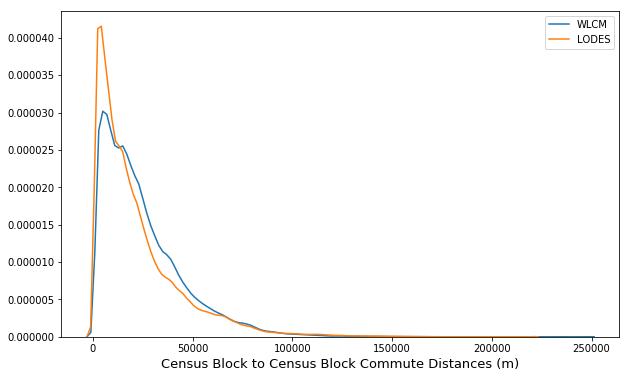

In [28]:
fig, ax = plt.subplots(figsize=(10,6))
sns.kdeplot(ods['distance_m'],ax=ax, label='WLCM')
sns.kdeplot(lodes_ods['distance_m'], ax=ax, label='LODES')
ax.set_xlabel('Census Block to Census Block Commute Distances (m)', fontsize=13)